### Potato Disease Classification

In [1]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

C:\Users\vivek\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivek\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\vivek\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [7]:
#Import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"Leaf_Detection_project",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


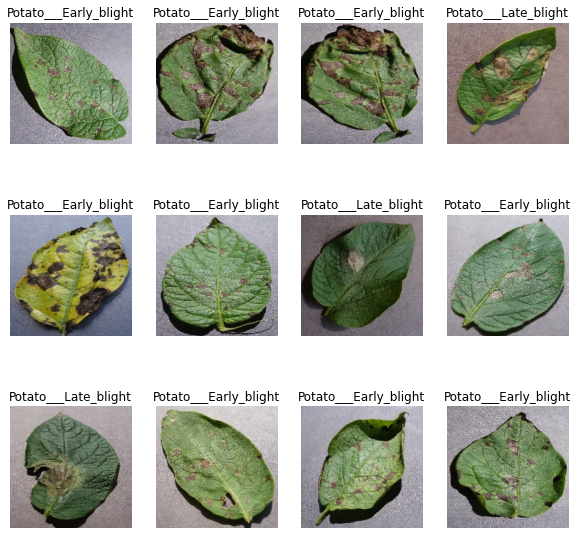

In [10]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

68

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [25]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
#Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [29]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 98s 2s/step - loss: 0.1547 - accuracy: 0.9444 - val_loss: 0.2399 - val_accuracy: 0.9375
Epoch 2/10
54/54 [==============================] - 138s 3s/step - loss: 0.1262 - accuracy: 0.9502 - val_loss: 0.2328 - val_accuracy: 0.9115
Epoch 3/10
54/54 [==============================] - 112s 2s/step - loss: 0.1023 - accuracy: 0.9647 - val_loss: 0.1727 - val_accuracy: 0.9531
Epoch 4/10
54/54 [==============================] - 101s 2s/step - loss: 0.1234 - accuracy: 0.9543 - val_loss: 0.2803 - val_accuracy: 0.9010
Epoch 5/10
54/54 [==============================] - 99s 2s/step - loss: 0.0933 - accuracy: 0.9664 - val_loss: 0.1382 - val_accuracy: 0.9479
Epoch 6/10
54/54 [==============================] - 100s 2s/step - loss: 0.0867 - accuracy: 0.9676 - val_loss: 0.1814 - val_accuracy: 0.9531
Epoch 7/10
54/54 [==============================] - 99s 2s/step - loss: 0.0879 - accuracy: 0.9670 - val_loss: 0.1274 - val_accuracy: 0.9583
Epoch 8/10
54/54

In [32]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 370ms/step - loss: 0.1191 - accuracy: 0.9648


In [33]:
scores

[0.11909165978431702, 0.96484375]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])


10

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.1546587198972702,
 0.12624919414520264,
 0.10228368639945984,
 0.1233953908085823,
 0.09332400560379028]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [47]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

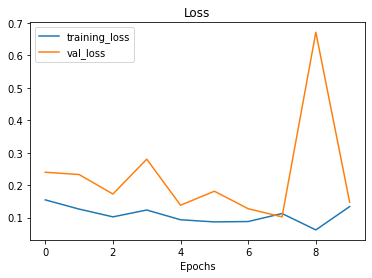

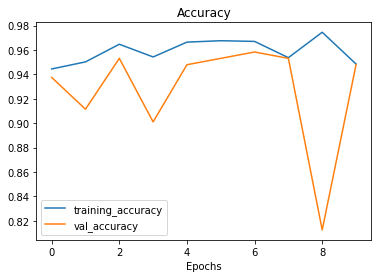

In [49]:
plot_loss_curves(history)

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


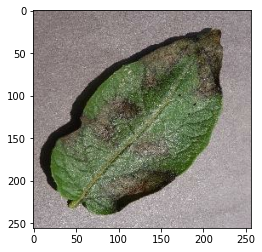

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

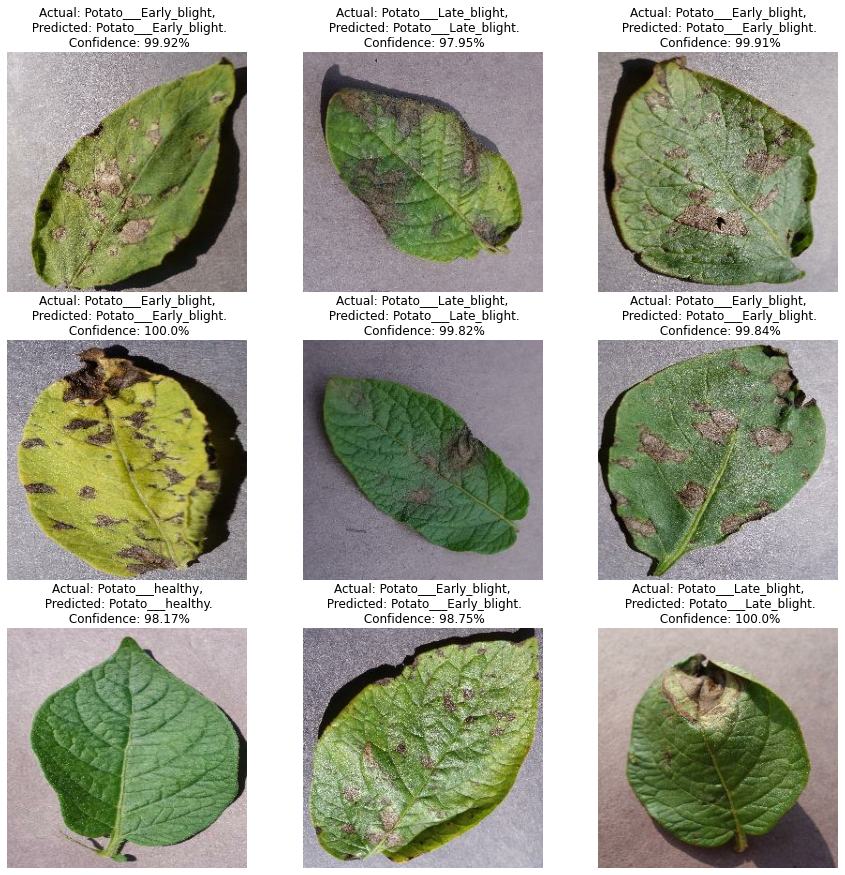

In [60]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [56]:
#Saving the Model
#model_version=1
#model.save(f"D:\Leaf_Detection_project/{model_version}")


INFO:tensorflow:Assets written to: D:\Leaf_Detection_project/1\assets


In [65]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model.h5')



In [66]:
y_pred = model.predict(test_ds)


In [67]:
y_pred

array([[4.89665195e-03, 9.95045304e-01, 5.79732041e-05],
       [9.99408364e-01, 5.91239368e-04, 3.92495934e-07],
       [9.96863842e-01, 3.11408099e-03, 2.20922830e-05],
       [2.93505727e-04, 9.99706447e-01, 4.86347211e-08],
       [9.99390602e-01, 6.09256153e-04, 9.51906287e-08],
       [9.99320030e-01, 6.79102435e-04, 8.77395109e-07],
       [9.99956965e-01, 4.30109721e-05, 1.80555504e-09],
       [9.99959230e-01, 4.07773223e-05, 3.54475667e-08],
       [9.99625206e-01, 3.73954972e-04, 8.17280409e-07],
       [9.99829888e-01, 1.70074010e-04, 3.25214217e-10],
       [9.99967098e-01, 3.28568785e-05, 2.28601493e-08],
       [6.73863542e-05, 9.99185145e-01, 7.47467740e-04],
       [9.99628901e-01, 3.68331326e-04, 2.70743567e-06],
       [2.84810340e-05, 9.99971509e-01, 3.89355073e-08],
       [9.99772131e-01, 2.27049037e-04, 8.37365803e-07],
       [6.37867022e-04, 9.99188840e-01, 1.73252949e-04],
       [1.07773929e-03, 9.98922229e-01, 1.27601936e-07],
       [9.98654366e-01, 1.34557

In [68]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)


In [69]:
y_pred


array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0,
       1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 2, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1], dtype=int64)